# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number :

## Student 1 
### Name : Nikhil Saldanha
### ID : 4998707

## Student 2
### Name : Sharwin Bobde
### ID : 5011639

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats import spearmanr
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from preprocessing import *

## 1. Familiarization and discretization task – 1 A4

### Encode Labels and Drop Background Flows

- normal = 0
- botnet = 1
- background = 2

In [6]:
df_encoded = encode_labels(df)
df_filtered = drop_background_flows(df_encoded)

In [7]:
df_encoded["Label"].value_counts()

2    1187592
1     106352
0      15847
Name: Label, dtype: int64

The counts of the flows match what is given on the website

### Check NaNs

In [9]:
df.isna().sum()

StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport          6987
Dir               0
DstAddr           0
Dport        104215
State          1228
sTos          12852
dTos         186791
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64

### Encode features

In [13]:
df_encoded.loc[df_encoded["Sport"].isna(), "Sport"] = "UNK"
sport_enc = LabelEncoder()
df_encoded.loc[:, "Sport"] = sport_enc.fit_transform(df_encoded["Sport"])

df_encoded.loc[df_encoded["Dport"].isna(), "Dport"] = "UNK"
dport_enc = LabelEncoder()
df_encoded.loc[:, "Dport"] = dport_enc.fit_transform(df_encoded["Dport"])

df_encoded.loc[df_encoded["State"].isna(), "State"] = "UNK"
state_enc = LabelEncoder()
df_encoded.loc[:, "State"] = state_enc.fit_transform(df_encoded["State"])

df_encoded.loc[df_encoded["sTos"].isna(), "sTos"] = -999
stos_enc = LabelEncoder()
df_encoded.loc[:, "sTos"] = stos_enc.fit_transform(df_encoded["sTos"])

df_encoded.loc[df_encoded["dTos"].isna(), "dTos"] = -999
dtos_enc = LabelEncoder()
df_encoded.loc[:, "dTos"] = dtos_enc.fit_transform(df_encoded["dTos"])

proto_enc = LabelEncoder()
df_encoded.loc[:, "Proto"] = proto_enc.fit_transform(df_encoded["Proto"])

dir_enc = LabelEncoder()
df_encoded.loc[:, "Dir"] = dir_enc.fit_transform(df_encoded["Dir"])

srcaddr_enc = LabelEncoder()
df_encoded.loc[:, "SrcAddr"] = srcaddr_enc.fit_transform(df_encoded["SrcAddr"])

dstaddr_enc = LabelEncoder()
df_encoded.loc[:, "DstAddr"] = dstaddr_enc.fit_transform(df_encoded["DstAddr"])

In [34]:
df_filtered = drop_background_flows(df_encoded)

In [35]:
df_filtered["Label"].value_counts()

1    106352
0     15847
Name: Label, dtype: int64

### Find correlations between features and label

### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

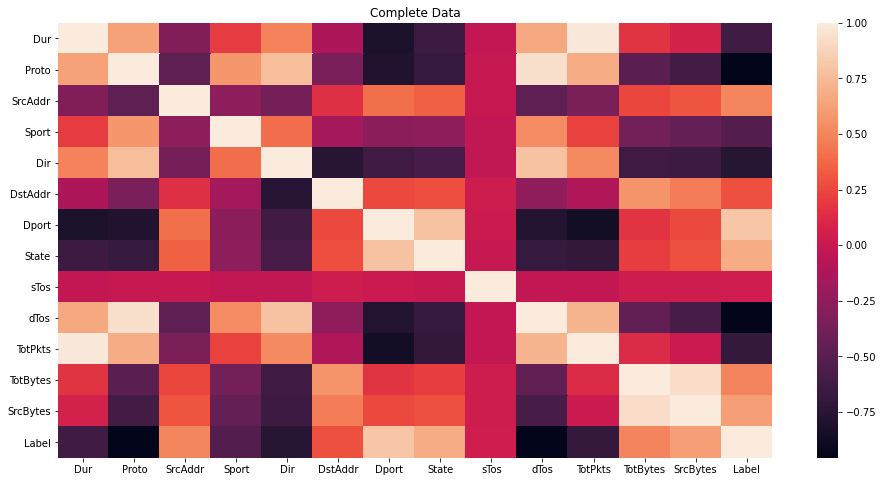

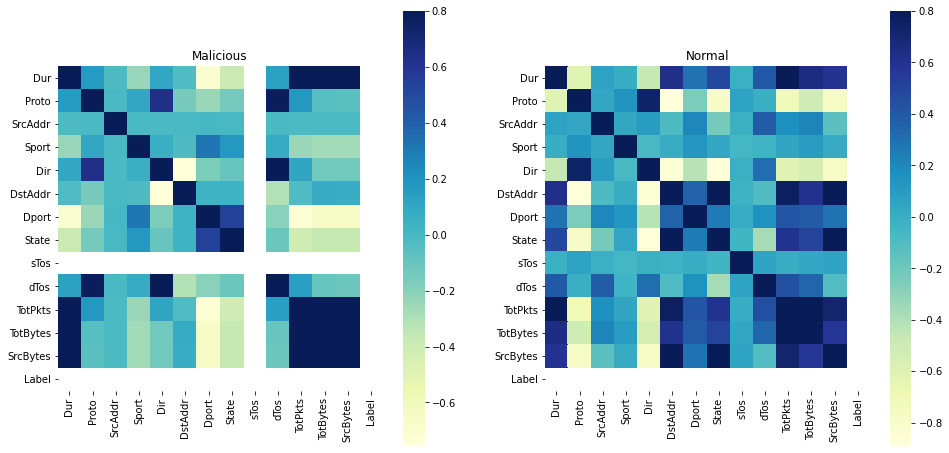

In [42]:
#correlation matrices
f, (ax1) = plt.subplots(1,figsize =(16, 8))
sns.heatmap(df_filtered.corr("spearman"))
ax1.set_title('Complete Data')
plt.show()


f, (ax1, ax2) = plt.subplots(1,2,figsize =(16, 8))

sns.heatmap(df_filtered[df_filtered["Label"] == 1].corr("spearman"), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Malicious')

sns.heatmap(df_filtered[df_filtered["Label"] == 0].corr("spearman"), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

### Find correlations between TotBytes, Dur and label

In [10]:
coef, p = spearmanr(df_filtered["Label"], df_filtered["TotBytes"])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.501
Samples are correlated (reject H0) p=0.000


In [11]:
coef, p = spearmanr(df_filtered["Label"], df_filtered["Dur"])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: -0.627
Samples are correlated (reject H0) p=0.000


### 1b. Discretize selected features

Find the optimal number of bins for discretization

- Use kmeans for discretization
- Use the elbow method by plotting the within cluster sum of squares vs number of clusters
- Use cluster labels as the discretized values

In [12]:
def visualize_discretization(feature, min_k=2, max_k=15):
    distortions = {}
    kmeans_models = {}
    for k in tqdm(range(min_k, max_k)):
        kmeans_model = KMeans(n_clusters=k)
        kmeans_model.fit(feature)
        kmeans_models[k] = kmeans_model
        distortions[k] = kmeans_model.inertia_

    plt.figure(figsize=(16,8))
    plt.plot(range(min_k, max_k), list(distortions.values()), 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
    return kmeans_models, distortions

### Discretization of TotBytes

100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


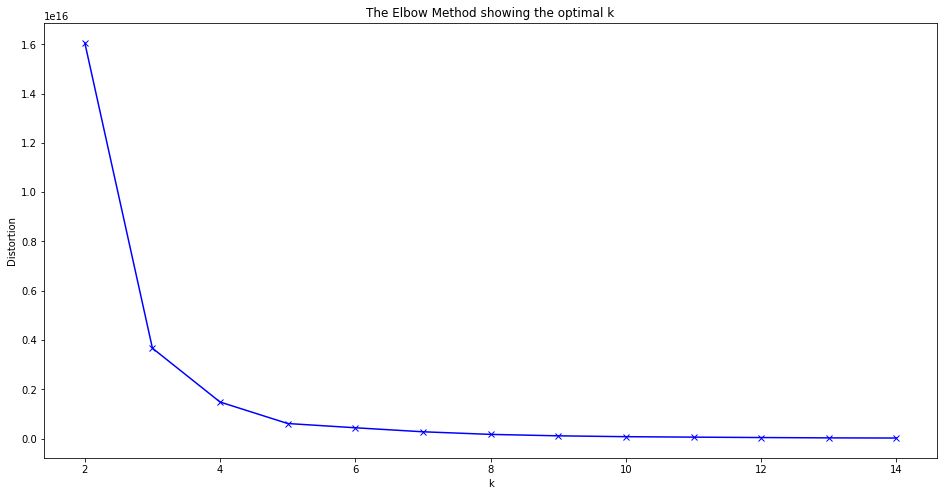

In [13]:
tot_bytes = df_filtered["TotBytes"].to_numpy().reshape(-1, 1)
kmeans_models, distortions = visualize_discretization(tot_bytes)

Choosing k = 5

In [26]:
# discretize
df_filtered.loc[:, "TotBytes_"] = kmeans_models[4].predict(tot_bytes)

/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [27]:
df_filtered.TotBytes_.value_counts()

3    97507
0    11585
2     7348
1     5759
Name: TotBytes_, dtype: int64

### Discretization of TotBytes

100%|██████████| 13/13 [00:20<00:00,  1.61s/it]


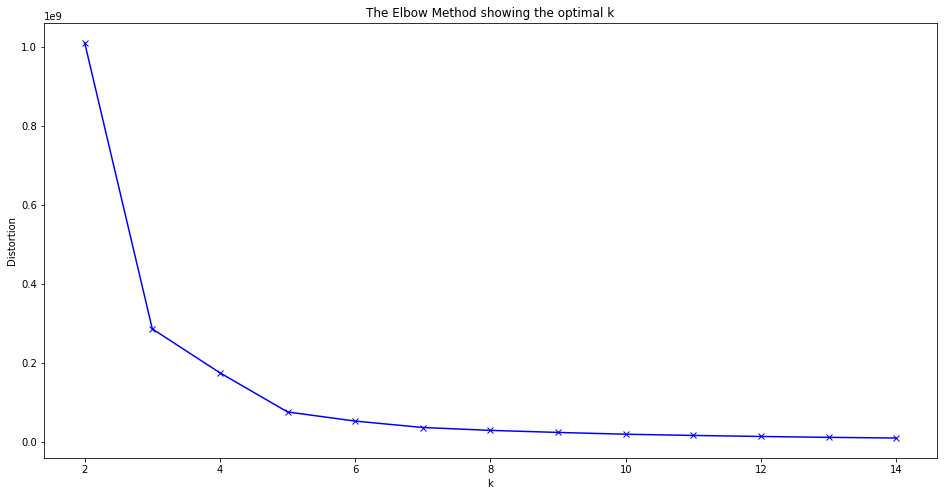

In [28]:
dur = df_filtered["Dur"].to_numpy().reshape(-1, 1)
kmeans_models, distortions = visualize_discretization(dur)

Choosing k = 5

In [17]:
# discretize
df_filtered.loc[:, "Dur_"] = kmeans_models[5].predict(dur)

/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/nikilsaldanaha/Documents/University/q4/Cyber Data Analytics/project/cyber-data-analytics/env/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [18]:
df_filtered.Dur_.value_counts()

0    111308
1      7284
4      2168
3      1307
2       132
Name: Dur_, dtype: int64

### Encoding using Attributes Mapping algorithm

_Algorithm 1 from [G. Pellegrino et.al. Learning Behavioral Fingerprints From Netflows Using Timed Automata](http://dl.ifip.org/db/conf/im/im2017/036.pdf)_

We combine `TotBytes` and `Dur` using this algorithm

In [29]:
num_bins = {"TotBytes_": 4, "Dur_": 5}

In [30]:
def attribute_mapping_encode(row):
    code = 0
    features = row.index
    space_size = reduce((lambda x, y: num_bins[x] * num_bins[y]), features)
    for feature in features:
        code = code + row[feature]*space_size/num_bins[feature]
        space_size = space_size/num_bins[feature]
    return code

In [31]:
df_filtered["TotBytes_Dur"] = df_filtered[["TotBytes_", "Dur_"]].apply(attribute_mapping_encode, axis=1)

<ipython-input-31-72fae5463242>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["TotBytes_Dur"] = df_filtered[["TotBytes_", "Dur_"]].apply(attribute_mapping_encode, axis=1)


Text(0.5, 1.0, 'Distribution of discretized feature for Normal Flows')

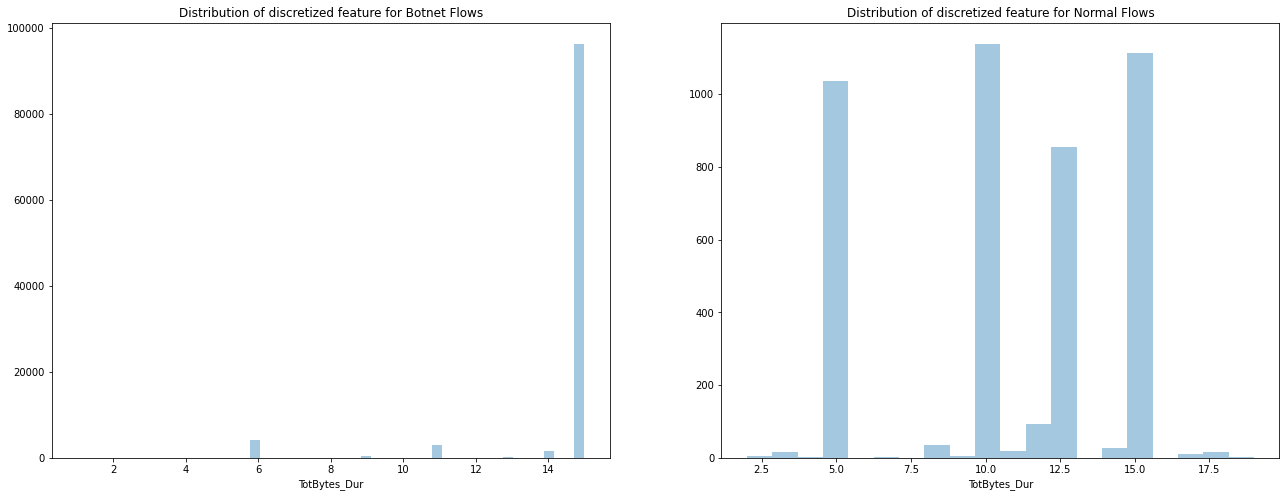

In [32]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.distplot(df_filtered[(df_filtered["Label"] == 1)&(df_filtered["TotBytes_Dur"] > 0)]["TotBytes_Dur"], kde=False, ax=ax1)
ax1.set_title("Distribution of discretized feature for Botnet Flows")
sns.distplot(df_filtered[(df_filtered["Label"] == 0)&(df_filtered["TotBytes_Dur"] > 0)]["TotBytes_Dur"], kde=False, ax=ax2)
ax2.set_title("Distribution of discretized feature for Normal Flows")

In [33]:
coef, p = spearmanr(df_filtered["Label"], df_filtered["TotBytes_Dur"])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.749
Samples are correlated (reject H0) p=0.000


### 1b. Answers and explanation

1. Explanation of visualization of two features that are most relevant for modeling the behavior of the infected host
2. Do you observe any behavior in the two features that could be useful for detecting the infection?

## 2. Frequent task – 1/2 A4 (Nikhil Saldanha)

### 2a. Use the SPACE SAVING algorithm

### 2b. Analysis and answers to the questions

1. What are the 10 most frequent 3-grams and their frequencies when approximated?
2. Explain any approximation errors you observe

## 3. Sketching task – 1/2 A4 (Individual)

### 3a. COUNT-MIN sketch


### 3b. Analysis and answers to the questions

## 4. Min-wise locality sensitive hashing task – 1/2 A4 (Nikhil Saldanha)

### 4a. Implementation

### 4b. Analysis and answers to the questions

1. Compare the run-time of a pair-wise distance computation with one that only considers profiles that end in the same bin.

2. Explain any differences you observe


## 5. Random hyperplane locality sensitive hashing task – 1/2 A4 (Individual)

### 5a. Implementation - locality sensitive hashing

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Botnet profiling task – 1/2 A4

### 6a. Learn a sequential model

### 6b. Analysis and answers to the questions.

## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


### 7b. Analysis and answers to the questions.

## 8. Bonus Task 1/2 A4

### 8a. Provide implementation and analysis.